<img src="images/JHI_STRAP_Web.png" style="width: 150px; float: right;">

# Supplementary Information: Holmes *et al.* 2017

# 3. Crossvalidation

This notebook describes analysis of 10-fold crossvalidation data of a Bayesian hierarchical model of the effects of control (growth) and treatment (passage) on individual genes from *E. coli* DH10B (carrier) and Sakai (BAC load), to subsets of data obtained using a multi-*E. coli* microarray.

Much of the code for the visualisation, analysis and data manipulation of the fitting results is found in the associated Python module `tools.py`, which should also be present in this directory.

## Table of Contents

 1. [Crossvalidation summary](#summary)
 2. [Load results](#load)
    1. [Load full fit](#loadfit)
    2. [Merge crossvalidation and fit](#merge)    
 3. [Calculate prediction errors](#errors)
    1. [Error distributions](#errdist)
    2. [Error with respect to measured output intensity](#erroutput)
    3. [Error with respect to estimated treatment effect](#errtrt)
    4. [Error with respect to prediction interval](#errinterval)
 4. [Identifying locus tags that confer an advantage under treatment](#locus_tags)
    1. [Plotting distribution of effects](#plot_effects)
    2. [Identifying candidates](#candidates)

<a id="summary"></a>
## Crossvalidation summary

We will be loading predicted and actual *output* probe intensity data from a 10-fold crossvalidation, performed as described in the file `README.md` on the JHI cluster. 

The Stan model used to generate the crossvalidation results is identical in form to that used in the notebook `02-full_model_fit.ipynb` except that it is fit ten times, each time on a random 90% of the data, and a prediction made for the *output* probe intensity of the remaining 10% of the data, given the *input* probe intensity as a predictor. The results of these ten runs are combined in the file `10-fold_CV.tab`.

We can assess the applicability and success of the Stan model by investigating how well it can predict the *output* intensity of a probe, given its *input* intensity. We are conducting crossvalidation on the original data, for which we have measured *input* and *output* intensity data. We consider a prediction to be "correct" if the measured *output* intensity lies within the 90% credibility interval of the *predicted output* intensity.

## Python imports

In [1]:
%pylab inline

import os

import numpy as np
import pandas as pd
import pickle
import scipy
import seaborn as sns

import tools

import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


<a id="load"></a>
## Load results

We load data from the multiplexed run performed on the JHI cluster, as described in `README.md`. 

The column containing the experimentally-measured predictor (*input* intensity) is `log_input`, and the column containing the measured *output* probe intensity is `log_output`. 

The *predicted output* mean and median values for 1000 iterations of two chains are found in the columns `y_pred_mean` and `y_pred_median`. 5%, 25%, 75% and 95% percentiles for *predicted output* are given in the columns `y_pred_5pc`, `y_pred_25pc`, `y_pred_75pc` and `y_pred_95pc`. These can be combined to provide 50% and 90% credibility intervals.

In [2]:
# Crossvalidation results file
resultsfile = os.path.join("datasets", "10-fold_CV.tab")

# Load predictions from file
results = pd.read_csv(resultsfile, sep='\t', index_col=0)
print(results.shape)
print(results.columns)

(49872, 19)
Index(['probe', 'replicate', 'treatment', 'repXtrt', 'input', 'output',
       'log_input', 'log_output', 'match', 'locus_tag', 'probe_index',
       'locus_tag_index', 'y_pred_25pc', 'y_pred_5pc', 'y_pred_75pc',
       'y_pred_95pc', 'y_pred_mean', 'y_pred_median', 'y_pred_sem'],
      dtype='object')


In [3]:
results.head()

,probe,replicate,treatment,repXtrt,input,output,log_input,log_output,match,locus_tag,probe_index,locus_tag_index,y_pred_25pc,y_pred_5pc,y_pred_75pc,y_pred_95pc,y_pred_mean,y_pred_median,y_pred_sem
3748,A_07_P010704,1,0,rep1trt0,6121.405000,4410.934000,8.719547,8.391842,lcl|NC_010473.1_cds_WP_001264707.1_2,ECDH10B_RS00010,7283,5515,8.207355,7.773169,8.759557,9.188514,8.478224,8.474044,0.422746
824,A_07_P010704,1,1,rep1trt1,1759.515333,1240.375333,7.472794,7.123169,lcl|NC_010473.1_cds_WP_001264707.1_2,ECDH10B_RS00010,7283,5515,7.001091,6.533055,7.594323,8.066008,7.306416,7.318386,0.459718
4842,A_07_P010704,3,1,rep3trt1,1881.971667,1384.856333,7.540075,7.233352,lcl|NC_010473.1_cds_WP_001264707.1_2,ECDH10B_RS00010,7283,5515,7.045696,6.636837,7.657438,8.073024,7.352519,7.361376,0.456918
2571,A_07_P010704,3,0,rep3trt0,6026.244000,5050.760667,8.703879,8.527294,lcl|NC_010473.1_cds_WP_001264707.1_2,ECDH10B_RS00010,7283,5515,8.163663,7.737422,8.759350,9.151118,8.457870,8.459948,0.436123
913,A_07_P010704,2,0,rep2trt0,7012.786667,4197.077333,8.855490,8.342144,lcl|NC_010473.1_cds_WP_001264707.1_2,ECDH10B_RS00010,7283,5515,8.390002,7.998688,8.958506,9.368503,8.674096,8.674164,0.421373


The crossvalidation data has 49872 rows (one per probe, per experiment) and 20 columns, named as shown.

<a id="loadfit"></a>
### Load full fit

We will want to investigate how predictive performance compares with our estimate of parameters from a fit on full data, to see - for example - whether the genes for which we have confidence in a treatment effect are associated with good predictions of output probe intensity.

We load the model fit from notebook `02-full_model_fit.ipynb`.

In [4]:
# File containing pickled fit from notebook 02
fitfile = os.path.join("model_fits", "full_model_fit.pkl")

# Load array measurements and get locus tags
datafile = os.path.join("datasets", "normalised_array_data.tab")
indata = pd.read_csv(datafile, sep="\t")
locus_tags = indata['locus_tag'].unique()

# Load the pickled fit into `estimates`
fit = pickle.load(open(fitfile, 'rb'))
estimates = tools.extract_variable_summaries(fit, 'df', locus_tags)
estimates.head()  # inspect the data

,locus_tag,a_2.5pc,a_25pc,a_75pc,a_97.5pc,a_mean,a_median,a_sem,b_2.5pc,b_25pc,...,g_mean,g_median,g_sem,d_2.5pc,d_25pc,d_75pc,d_97.5pc,d_mean,d_median,d_sem
5515,ECDH10B_RS00010,0.029129,0.244940,0.332219,0.426666,0.276330,0.295267,0.097412,0.918105,0.937876,...,0.373606,0.386956,0.091973,-0.090580,-0.062259,-0.055452,-0.036866,-0.059451,-0.058879,0.011430
4705,ECDH10B_RS00020,0.169773,0.272327,0.336390,0.427064,0.303134,0.305796,0.060675,0.923711,0.938501,...,0.385294,0.391275,0.064762,-0.079569,-0.062273,-0.054959,-0.044358,-0.059307,-0.058405,0.008574
5475,ECDH10B_RS00060,0.092371,0.268534,0.338677,0.493763,0.297471,0.307758,0.099552,0.916767,0.938826,...,0.383268,0.389446,0.073516,-0.089941,-0.063986,-0.055564,-0.036741,-0.060844,-0.059464,0.012340
5474,ECDH10B_RS00065,0.091092,0.258078,0.334934,0.449760,0.294165,0.302821,0.081867,0.907745,0.938434,...,0.385307,0.391122,0.106802,-0.090234,-0.062454,-0.054761,-0.040138,-0.059514,-0.058488,0.011435
5469,ECDH10B_RS00070,0.083468,0.265716,0.334018,0.413204,0.291290,0.301167,0.073938,0.918311,0.938084,...,0.373458,0.389639,0.107962,-0.130703,-0.067450,-0.056503,-0.047106,-0.068497,-0.059957,0.022810


`estimates` contains the notebook `02-full_model_fit.ipynb` estimates of parameters for each gene, with percentiles enabling a 95% or 50% credibility interval to be estimated.

<a id="merge"></a>
### Merge crossvalidation and fit

We join the crossvalidation data with the fits for the corresponding genes, on the basis of `locus_tag`, to make plotting and analysis easier. We also reduce the columns in the dataset to the locus tag, probe ID, the treatment and replicate factor, the measured log-transformed *input* and *output* intensities, and the median and 90% CI for the *predicted output* intensity. We also keep the estimated median $\delta$ and associated 95% CI.

In [5]:
# Columns to keep from the merged data
resultscols = ['locus_tag', 'probe', 'replicate', 'treatment',
               'log_input', 'log_output', 'y_pred_5pc', 'y_pred_median', 'y_pred_95pc',
               'd_2.5pc', 'd_25pc', 'd_median', 'd_75pc', 'd_97.5pc']

# Merge fit estimates with observed data
results_merged = pd.merge(results, estimates,
                          how='outer',
                          left_on='locus_tag', right_on='locus_tag').loc[:, resultscols]
results_merged.head()

,locus_tag,probe,replicate,treatment,log_input,log_output,y_pred_5pc,y_pred_median,y_pred_95pc,d_2.5pc,d_25pc,d_median,d_75pc,d_97.5pc
0,ECDH10B_RS00010,A_07_P010704,1,0,8.719547,8.391842,7.773169,8.474044,9.188514,-0.09058,-0.062259,-0.058879,-0.055452,-0.036866
1,ECDH10B_RS00010,A_07_P010704,1,1,7.472794,7.123169,6.533055,7.318386,8.066008,-0.09058,-0.062259,-0.058879,-0.055452,-0.036866
2,ECDH10B_RS00010,A_07_P010704,3,1,7.540075,7.233352,6.636837,7.361376,8.073024,-0.09058,-0.062259,-0.058879,-0.055452,-0.036866
3,ECDH10B_RS00010,A_07_P010704,3,0,8.703879,8.527294,7.737422,8.459948,9.151118,-0.09058,-0.062259,-0.058879,-0.055452,-0.036866
4,ECDH10B_RS00010,A_07_P010704,2,0,8.855490,8.342144,7.998688,8.674164,9.368503,-0.09058,-0.062259,-0.058879,-0.055452,-0.036866


<a id="errors"></a>
## Calculate prediction error

We create two new columns to represent the error in crossvalidation prediction of *output* intensity:

* `y_pred_abs_error`: the absolute error (`y_pred_median` - `log_output`)
* `y_pred_rel_error`: the relative error (`y_pred_abs_error`/`log_output`)

In [6]:
# Calculate absolute and relative prediction error
results_merged['y_pred_abs_error'] = results_merged['y_pred_median'] - results_merged['log_output']
results_merged['y_pred_rel_error'] = results_merged['y_pred_abs_error']/results_merged['log_output']

<a id="errdist"></a>
### Error distributions

Inspect the distribution of these errors directly by plotting, there are some strongly outlying points with large error, but most prediction errors are close to zero.

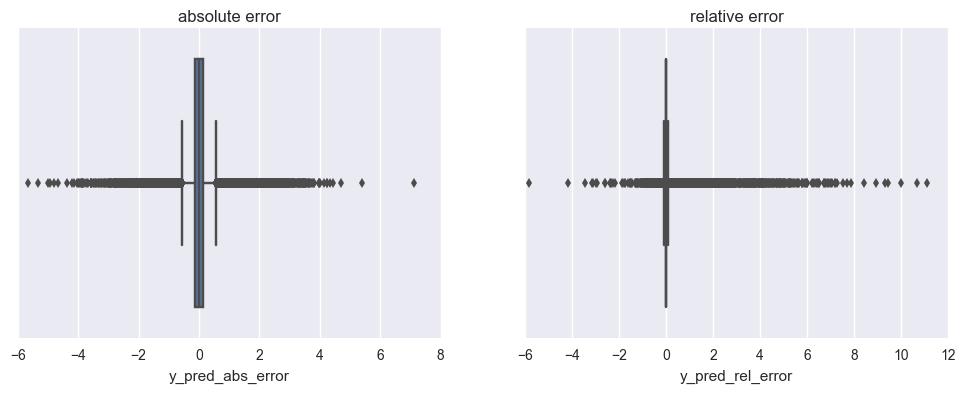

In [7]:
# Plot prediction errors boxplots
tools.plot_errors(results_merged)

<a id="erroutput"></a>
### Error with respect to measured intensity

By plotting the absolute and relative error in *output* intensity prediction against measured values, we can get an idea of whether the errors are uniformly distributed, or likely to be associated with weak measured intensities.

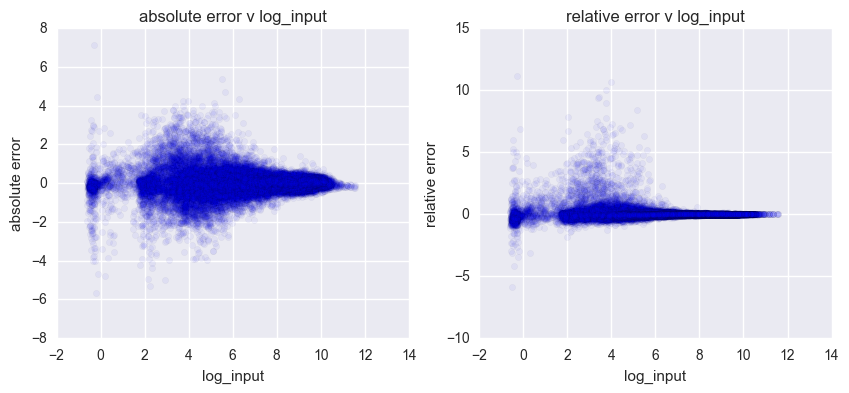

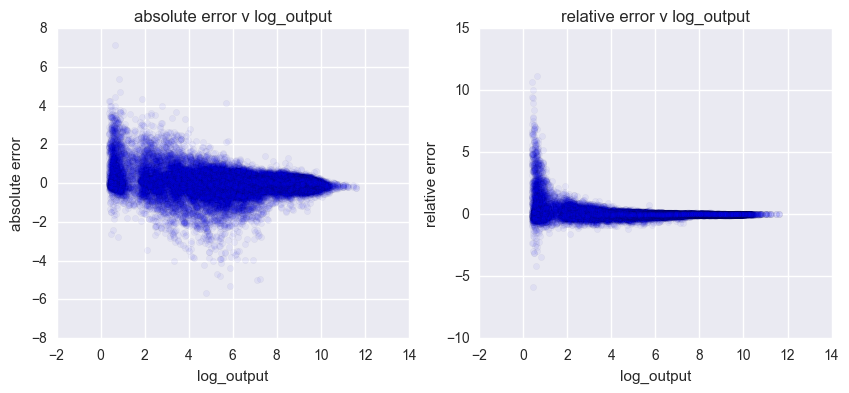

In [8]:
# Plot relative and absolute error wrt input and output
tools.plot_error_vs_column(results_merged, "log_input")
tools.plot_error_vs_column(results_merged, "log_output")

The plots above indicate that absolute and relative prediction errors are small for probes with intensities of 8 or less. In particular, probes with strong intensities have very low absolute and relative error. 

<a id="errtrt"></a>
### Error with respect to estimated treatment effect

By relating the absolute and relative error to the estimated treatment effect, we can interpret whether we should continue to be confident in the results of notebook 02. If the 25% percentile for our estimate of $\delta$ is greater than zero, then the 50% CI for that probe's gene does not include zero, and we interpret this as a positive effect due to treatment.

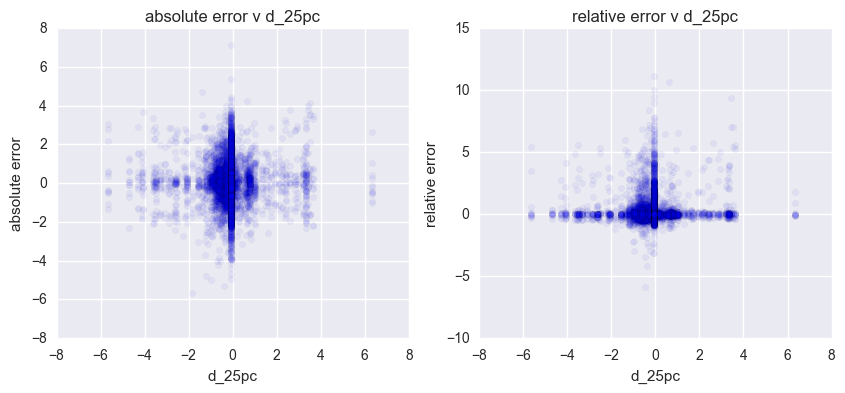

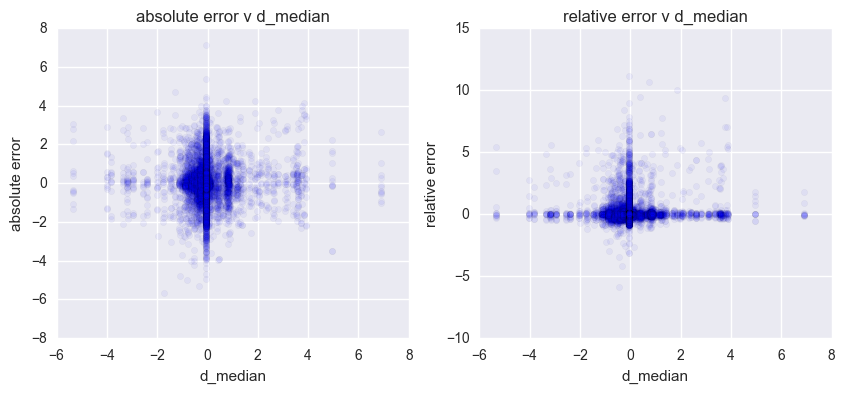

In [9]:
# Plot errors relative to 25% percentile for estimate of treatment effect
tools.plot_error_vs_column(results_merged, "d_25pc")
tools.plot_error_vs_column(results_merged, "d_median")

Median and 25% percentile values of $\delta_{j[i]}$ close to zero are associate most frequently with large errors. There are also some large absolute and relative errors associated with values that are positive and quite far from zero.

We subset the data to investigate this more closely, in the dataset `trt_pos` representing 72 locus tags with an estimated positive treatment effect.

In [10]:
# Subset data to positive estimates of delta only
trt_pos = results_merged[results_merged['d_25pc'] > 0]
trt_pos.head()

,locus_tag,probe,replicate,treatment,log_input,log_output,y_pred_5pc,y_pred_median,y_pred_95pc,d_2.5pc,d_25pc,d_median,d_75pc,d_97.5pc,y_pred_abs_error,y_pred_rel_error
14484,ECs0213,A_07_P059522,2,1,5.159603,4.717270,2.193692,2.928485,3.734658,-0.055868,0.277769,0.371717,0.460748,0.612089,-1.788785,-0.379199
14485,ECs0213,A_07_P059522,3,1,3.917283,0.557127,-0.231881,0.739816,1.753384,-0.055868,0.277769,0.371717,0.460748,0.612089,0.182689,0.327912
14486,ECs0213,A_07_P049262,3,1,3.818211,0.530552,-1.168272,-0.154745,0.819624,-0.055868,0.277769,0.371717,0.460748,0.612089,-0.685298,-1.291669
14487,ECs0213,A_07_P049262,3,0,6.592315,5.044490,5.045829,5.819429,6.580504,-0.055868,0.277769,0.371717,0.460748,0.612089,0.774939,0.153621
14488,ECs0213,A_07_P049262,1,1,4.499316,1.191359,1.461644,2.283064,3.019911,-0.055868,0.277769,0.371717,0.460748,0.612089,1.091705,0.916353


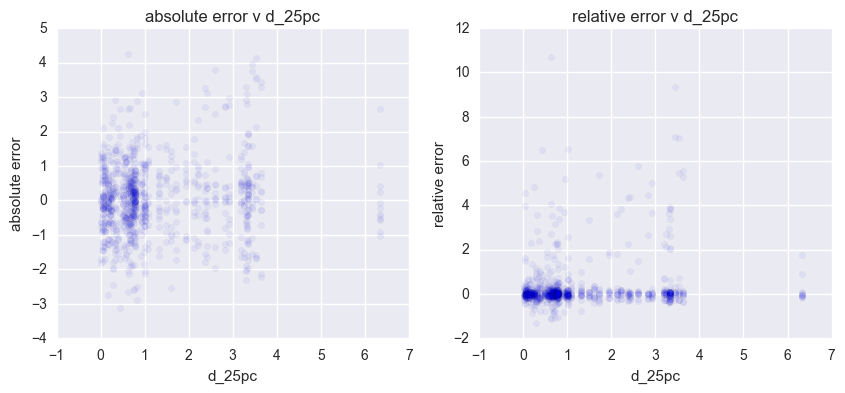

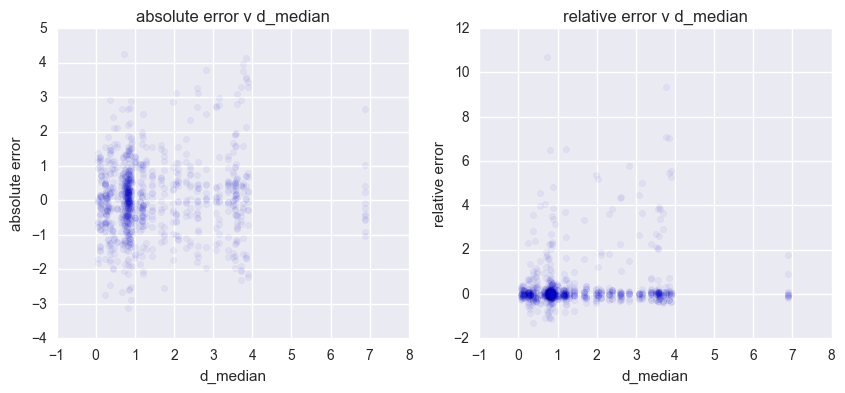

In [11]:
# Plot errors relative to 25% percentile for estimate of treatment effect
tools.plot_error_vs_column(trt_pos, "d_25pc")
tools.plot_error_vs_column(trt_pos, "d_median")

By visual inspection, most probe prediction errors are small in relative terms, but uniformly distributed in absolute terms. We can examine the error distributions for these probes with respect to log *input* and *output* intensities, as above.

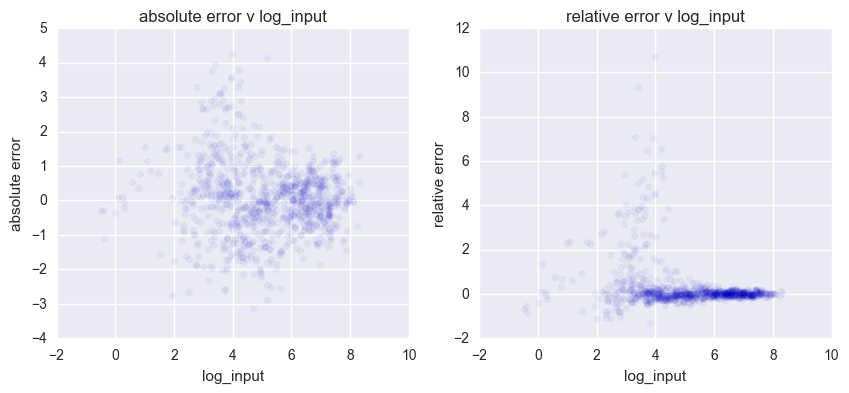

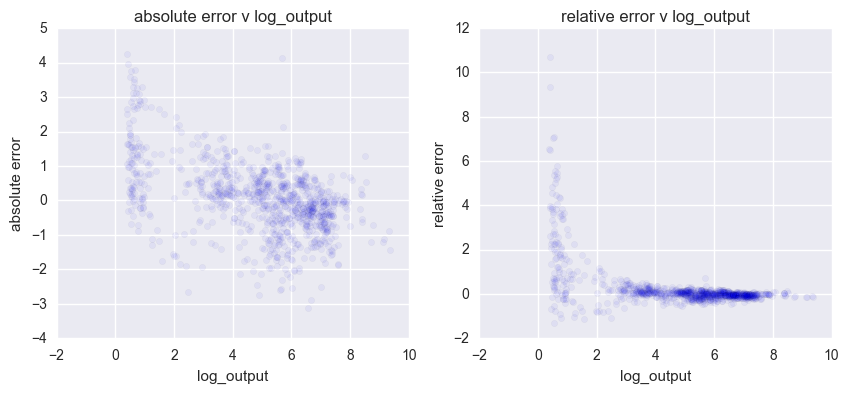

In [12]:
# Plot errors for positive treatment effects wrt measured intensities
tools.plot_error_vs_column(trt_pos, "log_input")
tools.plot_error_vs_column(trt_pos, "log_output")

These plots show that a large relative prediction error is clearly associated only with probes that have low measured *input* or *output* intensity.

<a id="errinterval"></a>
### Error with respect to prediction interval

As an estimate of prediction accuracy, we can calculate the number of observed output intensities that lie outwith the 90% credibility interval of the prediction.

In [13]:
# Find which probe predictions lay outwith the 90% credibility interval of prediction
errors = results_merged.loc[(results_merged['log_output'] < results_merged['y_pred_5pc']) |
                            (results_merged['log_output'] > results_merged['y_pred_95pc'])]
print(errors.shape, len(unique(errors['locus_tag'])))

(4186, 16) 1151


This identifies 4186/49872 probe predictions, covering 1151 locus_tags in total.

In [ ]:
TO HERE!!!

In [ ]:
# We can get a measure of how many probes are in error
error_probe_counts = errors['locus_tag'].groupby(errors['locus_tag']).agg(['count'])
error_probe_counts.columns=['probes_in_error']
sns.violinplot(error_probe_counts['probes_in_error']);

In [ ]:
# Which errors affect our predicted treatment?
errors_treatment = errors.loc[errors['treatment'] == 1]
errors_treatment.shape

In [ ]:
error_treatment_locus_tags = errors_treatment['locus_tag'].unique()
error_treatment_locus_tags.shape

In [ ]:
# We can get a measure of how many probes are in error
error_treatment_probe_counts = errors_treatment['locus_tag'].groupby(errors_treatment['locus_tag']).agg(['count'])
error_treatment_probe_counts.columns=['probes_in_error']
sns.violinplot(error_treatment_probe_counts['probes_in_error']);

In [ ]:
# How many Sakai tags in error for treatment?
len([tag for tag in error_treatment_locus_tags if tag.startswith('ECs')])

In [ ]:
# How many Sakai tags in error for treatment, with more than three probes?
df = error_treatment_probe_counts.loc[error_treatment_probe_counts['probes_in_error'] > 3]
df.shape

## How does prediction error relate to predicted treatment effect?

In [ ]:
# Plot error and relative error against mean estimate for delta
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.scatter(results_merged['d_mean'], results_merged['y_pred_error'], alpha=0.1)
ax1.set_xlabel('mean(delta)')
ax1.set_ylabel('error')
ax1.set_title('Prediction error')

ax2.scatter(results_merged['d_mean'], results_merged['y_pred_relative_error'], alpha=0.1)
ax2.set_xlabel('mean(delta)')
ax2.set_ylabel('relative error')
ax2.set_title('Prediction relative error');

Happily, the absolute and relative errors seem to be pretty constant, with estimate of $\delta_{j[i]}$. This is good news, as it means we can probably trust our predictions of large treatment effects - at least as far as those that have small treatment effects.

In [ ]:
# Add column dividing probes into those whose genes have a significant treatment
# effect, and those who don't.
results_merged['significant'] = abs(results_merged['d_mean']) - abs(results_merged['d_sem']) > 0

In [ ]:
# Visualise distributions of errors for probes
positives = results_merged.loc[results_merged['significant'] & (results_merged['d_mean'] > 0)]
positives.shape

In [ ]:
# Plot error and relative error against mean estimate for delta
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.scatter(positives['d_mean'], positives['y_pred_error'], alpha=0.1)
ax1.set_xlabel('mean(delta)')
ax1.set_ylabel('error')
ax1.set_title('Prediction error')

ax2.scatter(positives['d_mean'], positives['y_pred_relative_error'], alpha=0.1)
ax2.set_xlabel('mean(delta)')
ax2.set_ylabel('relative error')
ax2.set_title('Prediction relative error');

In [ ]:
# Visualise distribution of errors by probe, for each locus tag.
fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))
errplt = sns.boxplot(x=positives['locus_tag'], y=positives['y_pred_relative_error'], ax=ax1)
for item in errplt.get_xticklabels():
    item.set_rotation(90)
    item.set_fontsize(8)
errplt.set_title("Relative predicted error by probe (positive treatment effects)");

All of the genewise errors have distributions close to zero relative error, taken over all probes. However, some genes have very noisy responses (one or a few probes with large relative error).

In [ ]:
positives.loc[positives['locus_tag'] == 'ECs1172'][['probe', 'log_output', 'y_pred_5pc',
                                                    'y_pred_median', 'y_pred_95pc', 'd_median',
                                                    'y_pred_relative_error']].sort_values('probe')

In [ ]:
def plot_probe_predictions(locustag, df):
    """Plot prediction range and measured value for a specific gene"""
    ltdata = df.loc[df['locus_tag'] == locustag].sort_values(['probe', 'treatment', 'replicate'])
    plt.scatter(range(len(ltdata)), ltdata['log_output'], color='k')
    for idx, obs, plo, pmd, phi in zip(range(len(ltdata)),
                                       ltdata['log_output'],
                                       ltdata['y_pred_5pc'],
                                       ltdata['y_pred_median'],
                                       ltdata['y_pred_95pc']):
        if plo < obs < phi:
            lcolor = 'b-'
            pcolor = 'b.'
        else:
            lcolor = 'r-'
            pcolor = 'r.'
        plt.plot([idx, idx], [plo, phi], lcolor)
        plt.plot([idx, idx], [pmd, pmd], pcolor)
    plt.xticks(range(len(ltdata)), ltdata['probe'], rotation=90)
    plt.xlim(-1, len(ltdata))
    plt.title("Probe predictions: {0}, delta: {1}".format(locustag, ltdata['d_median'].unique()))

In [ ]:
plot_probe_predictions('ECs3501', positives)

In [ ]:
# Visualise distribution of delta estimates by probe, for each locus tag.
fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))
deltaplt = sns.boxplot(x=positives['locus_tag'], y=positives['d_median'], ax=ax1)
for item in deltaplt.get_xticklabels():
    item.set_rotation(90)
    item.set_fontsize(8)
deltaplt.set_title("Relative predicted error by probe (positive treatment effects)");